## Crop/select aera and calculate cloud fraction should be done in the same period.

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
%matplotlib inline
import datetime
from netCDF4 import Dataset # used for the netcdf files which contain lat, lon.
import seaborn as sns

In [2]:
path      = '//uio/lagringshotell/geofag/students/metos/hannasv/satelite_data_raw/'
path_era  = '//uio/lagringshotell/geofag/students/metos/hannasv/era_interim_data/'
nc_path   = '//uio/lagringshotell/geofag/students/metos/hannasv/satelite_coordinates/'

nc_files  = glob.glob(nc_path + '*.nc')
grb_files = glob.glob(path+"*.grb")
era = glob.glob(path_era+"*q.nc")

In [3]:
grb_file = grb_files[0]
era_file = era[0]
nc_file = nc_files[0]

data = xr.open_dataset(grb_file, engine = "pynio")
era = xr.open_dataset(era_file)

In [4]:
def timestamp(filename):
    """
    Returns the np.datetime64 [ns] for the current date.
    """
    splits = filename.split('-')
    # print(splits)
    ts = splits[5]
    year = ts[:4]
    month = ts[4:6]
    day = ts[6:8]
    hr = ts[8:10]
    minuts = ts[10:12]
    sek = ts[12:14]
    return np.datetime64( year+"-"+month+"-"+day+"T"+hr+":"+minuts+":"+sek )

## Retrieving coordinates from nc file. 
### Notes a nc is 10 times as large as a grib file that is why we only have one of them

In [5]:
ts = timestamp(grb_file)
data['time'] = ts
# Add time as a coordinate and dimension. 
data = data.assign_coords(time = data.time)
cmk = data['CLOUDM_P30_GSV0_I207'].values

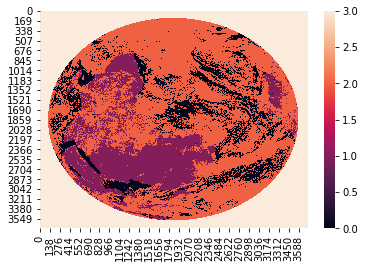

In [6]:
# as a reference that its upside down --> explain negative latitude values.
# 3 -off earth disk
# 2 - cloud
# 1 - not cloud over ocean and 0 not cloud over land

sns.heatmap(data['CLOUDM_P30_GSV0_I207'].values)

In [7]:
def fix_one_sat_file(filename):
    """
    filename : str
        full absoulute path to file.
    
    This reads a raw satelite file.
    Add time, longitude, latitude.
    """
    data = xr.open_dataset(filename, engine="pynio")

    ts = timestamp(filename)
    data['time'] = ts
    
    # Add time as a coordinate and dimension. 
    data = data.assign_coords(time = data.time)
    data = data.expand_dims(dim = 'time')
        
    # Rename dimenstions and coordinates 
    data = data.rename(name_dict={'xgrid_0': 'longitude', 
                                  'ygrid_0':'latitude', 
                                  'CLOUDM_P30_GSV0_I207':'tcc'}, inplace=True)
    # crop to correct region 
    # data = data.sel(latitude = slice(30,60))
    # data = data.sel(longitude = slice(-15, 42))

    tcc, counting = calc_all(data.tcc.values)
    
    data['tcc'].values = tcc
    data['xgrid_0'] = np.arange(-15, 42+0.75, 0.75)
    data['ygrid_0'] = np.arange(30, 60+0.75, 0.75)
    
    return data

# Get data from file with coordinates

In [8]:
rootgrp = Dataset(nc_file, "r", format="NETCDF4")
cloud_mask_array = rootgrp.variables["cloudMask"][:].data
lat_array = rootgrp.variables["lat"][:].data
lon_array = rootgrp.variables["lon"][:].data
lat_array[lat_array < -99] = np.nan # updates of disk values to nan
lon_array[lon_array < -99] = np.nan # updates of disk values to nan

# OBS! Data in grb files needs to be flipped left right to be coherant with netCDF files ..

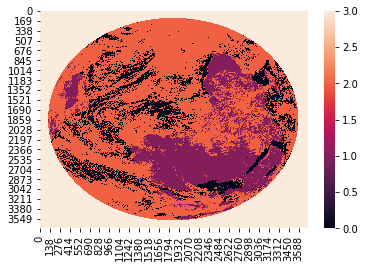

In [9]:
#sns.heatmap(np.fliplr(data['CLOUDM_P30_GSV0_I207'].values))

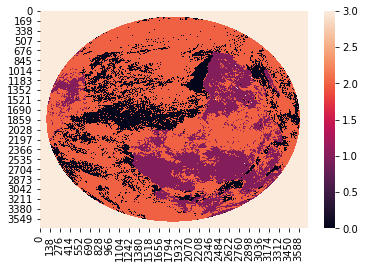

In [10]:
#sns.heatmap(cloud_mask_array)

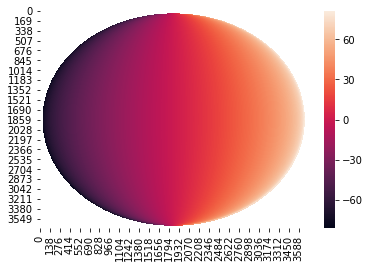

In [11]:
#sns.heatmap(lon_array)

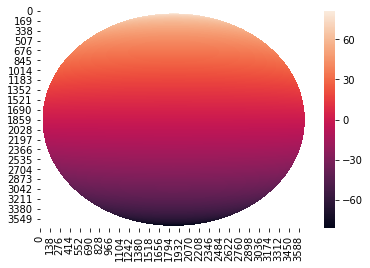

In [12]:
#sns.heatmap(np.flipud(lat_array))

In [13]:
#lat_array = np.flipud(lat_array)

# Må hente ut rader og transponere dem for at du skal kunne vektorisere trekke fra elementet i under i samme kolonne.

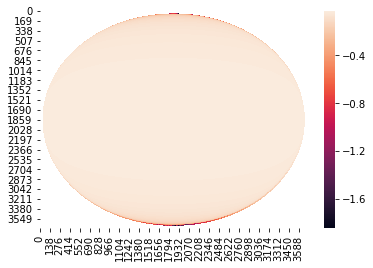

In [14]:
d_theta = (lat_array[1:, :].transpose() - lat_array[:-1, :].transpose() ).transpose() 
sns.heatmap(d_theta)

# Compute the d_phi and d_theta

In [15]:
d_phi   = lon_array[:, 1:] - lon_array[:, :-1]
d_theta = lat_array[:-1] - lat_array[1:]

In [16]:
pad     = np.ones((3712, 1))*np.nan # adding numpy to the axis the values 
d_phi   = np.concatenate((pad, d_phi), axis = 1)/2
d_theta = np.concatenate((pad.transpose(), d_theta), axis = 0)/2

# HVA BETYR DET EGENTLIG AT DENNE PADDES FORRAN.
## dET BETYR at y-x blir d_phi i punktet y.

[x, y
.., ..
.., ..
.., ..]

In [17]:
def area_grid_cell(c_lat, d_lat, d_lon):
    """
    c_lat : float
        Centre point longitude, latitude in degrees
        
    d_lat, d_lon : float
        delta lat lon in degrees

    Returns : area in km^2

    cdo : If the grid cell area have to be computed it is scaled with the earth radius to square meters.
    """   
    R = 6371000  # in M
    # area er egentlig R**2
    area = R*(-np.sin((c_lat - d_lat)*np.pi/180)+np.sin((c_lat + d_lat)*np.pi/180) )*(2*d_lon*np.pi/180) # R**2
    return area

# Comparing to ERA cdo gridarea calculated area 

# R*area = true/R

In [391]:
#area_grid_cell(era.latitude.values, 0.375, 0.375)

In [392]:
#(era.cell_area.values/6371000)[:,0]

# Relative error of area function  is of the order of one to ten thousands.

In [250]:
((era.cell_area.values/6371000)[:,0] - 
 area_grid_cell(era.latitude.values, 0.375, 0.375))/(era.cell_area.values/6371000)[:,0]
# now it should be similar to the area without dividing on R**2

array([-3.12421452e-05, -1.71448614e-05, -2.37248924e-05, -2.49084640e-05,
       -2.82969845e-05, -2.61183223e-05, -2.53686881e-05, -1.88600778e-05,
       -2.57744412e-05, -1.35826312e-05, -2.52589824e-05, -1.77305453e-05,
       -2.01730767e-05, -2.57623505e-05, -2.84077379e-05, -1.23473193e-05,
       -2.35944032e-05, -2.52830466e-05, -1.27436320e-05, -1.89843216e-05,
       -1.02162207e-05, -2.68743177e-05, -1.87319237e-05, -8.01250845e-06,
       -2.34479555e-05, -9.51600927e-06, -1.14140418e-05, -1.56891696e-05,
       -1.75971538e-05, -1.27021840e-05, -1.18020533e-05, -1.75833118e-05,
       -3.59088255e-06, -1.62341462e-05, -7.86484769e-06, -9.66189102e-06,
       -1.00998537e-05, -1.17082340e-05, -1.02311316e-05, -1.61551629e-06,
       -7.74892134e-06, -4.86021231e-06, -8.01870282e-06, -6.71752846e-06,
       -3.18098035e-06, -5.55378096e-06, -3.61788782e-06, -5.34868654e-06,
       -7.69794551e-07, -3.48823624e-06,  2.17328644e-06, -2.80270294e-06,
        2.73260504e-06, -

In [21]:
# Make this a loop over lat_lons?
lat_bondaries = np.array([[-15],
                          [30]])

BOUND =  np.array([[-0.75/2, 0.75/2],
                   [-0.75/2, 0.75/2]])

ranges = lat_bondaries + BOUND

In [22]:
lat_bondaries + BOUND

array([[-15.375, -14.625],
       [ 29.625,  30.375]])

In [23]:
lon_range = ranges[0, :]
lat_range = ranges[1, :]
min_lon, max_lon = lon_range
min_lat, max_lat = lat_range

In [24]:
d_phi   = d_phi.reshape(-1)
d_theta = d_theta.reshape(-1)

In [25]:
ranges[1,0], ranges[1,1]

(29.625, 30.375)

* up_cmk - era_down > 0 

* down_cmk - era_up < 0
* left_cmk - era_right < 0
* right_cmk - era_left > 0

Alle indexer he skal være med..?

In [26]:
ranges

array([[-15.375, -14.625],
       [ 29.625,  30.375]])

In [27]:
era_up    = ranges[1, 1]
era_down  = ranges[1, 0]
era_left  = ranges[0, 0]
era_right = ranges[0, 1]

In [28]:
era_up, era_down, era_left, era_right

(30.375, 29.625, -15.375, -14.625)

In [29]:
c_lon = lon_array.reshape(-1) #+ d_phi
c_lat = lat_array.reshape(-1) #+ d_theta

cmk_left  = c_lon - d_phi   #- era_right
cmk_right = c_lon + d_phi   #- era_left
cmk_up    = c_lat + np.abs(d_theta) #- era_down
cmk_down  = c_lat - np.abs(d_theta) #- era_up

In [532]:
idx_left_boundary  = np.intersect1d(np.argwhere(cmk_right > era_left),  np.argwhere(cmk_left < era_left) )
idx_right_boundary = np.intersect1d(np.argwhere(cmk_right > era_right), np.argwhere(cmk_left < era_right) )
idx_up_boundary    = np.intersect1d(np.argwhere(cmk_up > era_up), np.argwhere(cmk_down < era_up) )
idx_down_boundary  = np.intersect1d(np.argwhere(cmk_up > era_down), np.argwhere(cmk_down < era_down) )

/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.p

### get corners 

In [533]:
lower_right_corner = np.intersect1d(idx_down_boundary, idx_right_boundary)
lower_left_corner  = np.intersect1d(idx_down_boundary, idx_left_boundary)
upper_left_corner  = np.intersect1d(idx_up_boundary, idx_left_boundary)
upper_right_corner = np.intersect1d(idx_up_boundary, idx_right_boundary)

corner_idx = np.concatenate([lower_right_corner, lower_left_corner, 
                             upper_left_corner, upper_right_corner]) # corner idx

In [536]:
max_lon, min_lon = np.max(c_lon[corner_idx]), np.min(c_lon[corner_idx])
max_lat, min_lat = np.max(c_lat[corner_idx]), np.min(c_lat[corner_idx])

In [577]:
# removes corners
idx_down_boundary = idx_down_boundary[idx_down_boundary != lower_right_corner]
idx_down_boundary = idx_down_boundary[idx_down_boundary != lower_left_corner]

idx_up_boundary = idx_up_boundary[idx_up_boundary != upper_right_corner]
idx_up_boundary = idx_up_boundary[idx_up_boundary != upper_left_corner]

idx_left_boundary = idx_left_boundary[idx_left_boundary != upper_left_corner]
idx_left_boundary = idx_left_boundary[idx_left_boundary != lower_left_corner]

idx_right_boundary = idx_right_boundary[idx_right_boundary != upper_right_corner]
idx_right_boundary = idx_right_boundary[idx_right_boundary != lower_right_corner]

## Need to do this by boundary.

In [578]:
# subsection left boundary OLD
low_bound = np.argwhere( c_lat[idx_left_boundary] > min_lat  )
up_bound  = np.argwhere( c_lat[idx_left_boundary] < max_lat  )
sub_section_left = np.intersect1d(low_bound, up_bound)

/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


In [580]:
# subsection right boundary 
low_bound = np.argwhere( c_lat[idx_right_boundary] > min_lat )
up_bound  = np.argwhere( c_lat[idx_right_boundary] < max_lat)
sub_section_right = np.intersect1d(low_bound, up_bound)

/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less
  


In [583]:
# Subsection Down Boundary 
one = np.argwhere( c_lon[idx_down_boundary] > min_lon )
two = np.argwhere( c_lon[idx_down_boundary] < max_lon)
sub_section_down = np.intersect1d(one, two)

In [585]:
# subsection up boundary 
one = np.argwhere( c_lon[idx_up_boundary] > min_lon)
two = np.argwhere( c_lon[idx_up_boundary] < max_lon)
sub_section_up = np.intersect1d(one, two)

In [588]:
# test that these are empty 
t1 = np.intersect1d(idx_down_boundary, idx_up_boundary)
t2 = np.intersect1d(idx_right_boundary, idx_left_boundary)
assert len(t1) == len(t2) == 0

# THE ABOVE LINE SHOULD BE TRUE

# Take intersection between boundary indexes in the original long format to detect corners.
* Store all the new dlon and lat and dlat. 
* For each edge only one of these needs to be calculated. 
* area_grid_cell(c_lat, d_lat, d_lon) 

THE first two centres discussed are the longitude centres. 

### dx_left = (clm centre + dlon(phi) - era_centre)/2  (right boundary)

Above eq describes the centere of the new area. 

* If not corner -- one adjust one centre. 

### dx_right = (era_centre lon - (clm centre lon- dlon(phi)  this is the left bound  ) )/2

In [589]:
largeAREA = area_grid_cell(30, 0.375, 0.375)
largeAREA

945.3930343633116

In [659]:
# AREA left boundary
dlon_lf = ( era_left - (c_lon[idx_left_boundary][sub_section_left] + 
                         d_phi[idx_left_boundary][sub_section_left]))/2 # negative values

dlat_lf = d_theta[idx_left_boundary][sub_section_left]

lat_lf = c_lat[idx_left_boundary][sub_section_left]
lon_lf = c_lon[idx_left_boundary][sub_section_left]

a = np.sum(area_grid_cell(lat_lf, dlat_lf, np.abs(dlon_lf)))

fraction_left = (cloud_mask_array[idx_left_boundary][sub_section_left]*area_grid_cell(lat_lf, 
                                                                                      dlat_lf,
                                                                                      dlon_lf)/largeAREA).sum()
fraction_left

-0.022512201510369475

In [660]:
dlon_lf

array([-0.00400949, -0.0071826 , -0.0103488 , -0.01350784, -0.01665926,
       -0.00288868, -0.00603342, -0.00917101, -0.01230097, -0.01542425,
       -0.00165844, -0.00477457, -0.00788355, -0.01098537, -0.01408005,
       -0.00031972, -0.00340796, -0.0064888 , -0.00956249, -0.01262951,
       -0.01568961])

In [657]:
# AREA right boundary
# dlon right boundary - of one era interim 
dlon_rb = (c_lon[idx_right_boundary][sub_section_right] - d_phi[idx_right_boundary][sub_section_right] -
           era_right)/2

dlat_rb = d_theta[idx_right_boundary][sub_section_right]

lat_rb = c_lat[idx_right_boundary][sub_section_right]
lon_rb = c_lon[idx_right_boundary][sub_section_right]

b = np.sum(area_grid_cell(lat_rb, dlat_rb, np.abs(dlon_rb)))

fraction_right = (cloud_mask_array[idx_right_boundary][sub_section_right]*area_grid_cell(lat_rb, 
                                                                                      dlat_rb, 
                                                                                      dlon_rb)/largeAREA).sum()

In [654]:
# AREA down boundary
dlat_down = (era_down - c_lat[idx_down_boundary][sub_section_down] + 
              d_theta[idx_down_boundary][sub_section_down])/2

lat_down = era_down + dlat_down

dlon_down = d_phi[idx_down_boundary][sub_section_down]
lon_down =  c_lon[idx_down_boundary][sub_section_down]

c = np.sum(area_grid_cell(lat_down, dlat_down, dlon_down))

fraction_down = (cloud_mask_array[idx_down_boundary][sub_section_down]*area_grid_cell(lat_down, 
                                                                                      dlat_down, 
                                                                                      dlon_down)/largeAREA).sum()

In [655]:
largeAREA

945.3930343633116

In [630]:
area_grid_cell(lat_down, dlat_down, np.abs(dlon_down))

array([0.04152519, 0.09165511, 0.14143551, 0.19129227, 0.24086456,
       0.29028956, 0.33958792, 0.38875287, 0.4377845 , 1.30694129,
       1.35815028, 1.40943764, 1.46046648, 1.51131765, 1.56207559,
       1.61269895, 1.66303259, 1.71333691, 1.76344627, 1.81358324,
       1.86342428, 1.91307686])

In [656]:
# AREA up boundary
dlat_up = (era_up - (c_lat[idx_up_boundary][sub_section_up] - 
                     d_theta[idx_up_boundary][sub_section_up]) )/2

lat_up = era_up - dlat_up 
lon_up = c_lon[idx_up_boundary][sub_section_up]
dlon_up = d_phi[idx_up_boundary][sub_section_up]

d = np.sum(area_grid_cell(lat_up, dlat_up, np.abs(dlon_up)))

fraction_up = (cloud_mask_array[idx_up_boundary][sub_section_up]*area_grid_cell(lat_up, 
                                                             dlat_up, 
                                                             dlon_up)/largeAREA).sum()

In [653]:
fraction_up

0.022175662545409716

## Find the cells inside boundaried

In [599]:
idx_centre_one = np.intersect1d(np.argwhere(cmk_left  > era_left), 
                                np.argwhere(cmk_right < era_right))

/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in less
  


In [600]:
idx_centre_two = np.intersect1d(np.argwhere(cmk_up   < era_up), 
                                np.argwhere(cmk_down >  era_down))

/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
/uio/hume/student-u89/hannasv/anaconda3/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in greater
  


In [604]:
lat_centre_cells =   c_lat[idx_centre_cells]
lon_centre_cells =   c_lon[idx_centre_cells]
dlon_centre      =   d_phi[idx_centre_cells]
dlat_centre      = d_theta[idx_centre_cells]

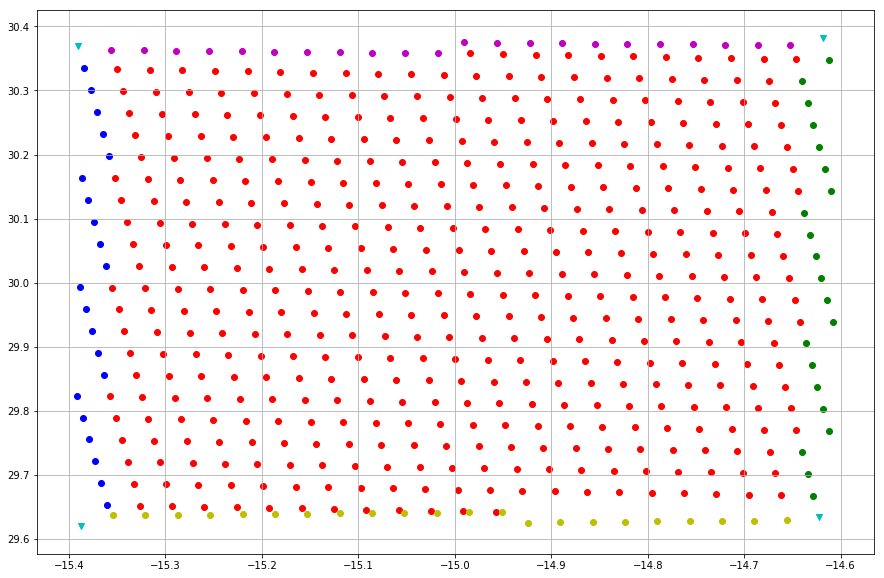

In [605]:
fig, ax = plt.subplots(figsize=(15, 10))

plt.scatter(lon_centre_cells, lat_centre_cells, color = 'r')
plt.scatter(lon_lf, lat_lf, color = 'b')
plt.scatter(lon_rb, lat_rb, color = 'g')
plt.scatter(lon_down, lat_down, color = 'y')
plt.scatter(lon_up, lat_up, color = 'm')
plt.scatter( c_lon[corner_idx], c_lat[corner_idx], color = 'c', marker = 'v' )
plt.grid( )
#plt.()

In [608]:
e = np.sum()

In [609]:
area_grid_cell(lat_centre_cells, dlat_centre, dlon_centre);

In [610]:
largeAREA*0.009

8.508537309269803

In [611]:
(a + b+c +d +e)/largeAREA  # the extra values is because of corners ..? 

1.0083537240870324

In [612]:
a, b, c, d, e

(21.282878496086525,
 20.35377773931998,
 23.114175488033233,
 20.964716902821728,
 867.5750382999236)

In [639]:
cloud_mask_array = rootgrp.variables["cloudMask"][:].data

In [640]:
cloud_mask_array

array([[3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       ...,
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.],
       [3., 3., 3., ..., 3., 3., 3.]], dtype=float32)

In [641]:
cloud_mask_array[cloud_mask_array == 1] = 0 
cloud_mask_array[cloud_mask_array == 2] = 1 
cloud_mask_array[cloud_mask_array == 3] = np.nan

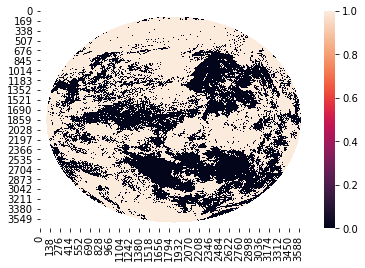

In [642]:
sns.heatmap(cloud_mask_array)

In [644]:
cloud_mask_array = cloud_mask_array.reshape(-1)

In [650]:
fraction_centre = (cloud_mask_array[idx_centre_cells]*area_grid_cell(lat_centre_cells, 
                                                             dlat_centre, 
                                                             dlon_centre)/area_grid_cell(30, 0.375, 0.375)).sum()

In [651]:
fraction_centre

0.9176871489054331

In [ ]:
counter = 0
for filename in grb_files:# grb file of satellite image...
    print(filename)
    if counter == 0:
        print("enters 0")
        clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
        ds = xr.Dataset({'tcc': (['latitude', 'longitude'],  tcc),
                         'nr_nans':(['latitude', 'longitude'], cnt_nans), 
                        'nr_cells':(['latitude', 'longitude'], cnt_cells)},
                         coords={'longitude': (['longitude'], lon),
                                 'latitude': (['latitude'], lat), 
                                })

        ts = timestamp(filename)
        ds['time'] = ts

        # Add time as a coordinate and dimension. 
        ds = ds.assign_coords(time = data.time)
        ds = ds.expand_dims(dim = 'time')
        counter += 1

    else:
        print("enters 1")
        clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
        new_ds = xr.Dataset({'tcc': (['latitude', 'longitude'],  tcc),
                             'nr_nans':(['latitude', 'longitude'], cnt_nans), 
                             'nr_cells':(['latitude', 'longitude'], cnt_cells)},
                              coords={'longitude': (['longitude'], lon),
                                      'latitude': (['latitude'], lat), 
                                       })

        ts = timestamp(filename)
        new_ds['time'] = ts

        # Add time as a coordinate and dimension. 
        new_ds = new_ds.assign_coords(time = data.time)
        new_ds = new_ds.expand_dims(dim = 'time')

        ds.merge(new_ds)

        counter += 1

print(ds)

In [ ]:
new_ds

In [ ]:
ds

In [ ]:
new_ds = xr.Dataset({'tcc': (['latitude', 'longitude'],  tcc),
                     'nr_nans':(['latitude', 'longitude'], cnt_nans), 
                     'nr_cells':(['latitude', 'longitude'], cnt_cells)},
                    
                      coords={'longitude': (['longitude'], lon),
                              'latitude': (['latitude'], lat) })

ts = timestamp(filename)
new_ds['time'] = ts

# Add time as a coordinate and dimension. 
new_ds = new_ds.assign_coords(time = data.time)
new_ds = new_ds.expand_dims(dim = 'time')

In [ ]:
new_ds

In [ ]:
ds

In [ ]:
new_ds

In [ ]:
def create_grb_file_by_filenames(filenames):
    counter = 0
    for filename in filenames:# grb file of satellite image...
        print()
        if counter == 0:
            print("enters 0")
            clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
            ds = xr.Dataset({'tcc': (['latitude', 'logitude'],  tcc),
                             'nr_nans':(['latitude', 'logitude'], cnt_nans), 
                            'nr_cells':(['latitude', 'logitude'], cnt_cells)},
                             coords={'longitude': (['longitude'], lon),
                                     'latitude': (['latitude'], lat), 
                                    })

            ts = timestamp(filename)
            ds['time'] = ts

            # Add time as a coordinate and dimension. 
            ds = ds.assign_coords(time = data.time)
            ds = ds.expand_dims(dim = 'time')
            counter += 1
            
        else:
            print("enters 1")
            clm, cnt_cells, cnt_nans = calc_all(filename, nc_file = nc_files[0])
            new_ds = xr.Dataset({'tcc': (['latitude', 'logitude'],  tcc),
                             'nr_nans':(['latitude', 'logitude'], cnt_nans), 
                            'nr_cells':(['latitude', 'logitude'], cnt_cells)},
                             coords={'longitude': (['longitude'], lon),
                                     'latitude': (['latitude'], lat), 
                                    })

            ts = timestamp(filename)
            new_ds['time'] = ts

            # Add time as a coordinate and dimension. 
            new_ds = new_ds.assign_coords(time = data.time)
            new_ds = new_ds.expand_dims(dim = 'time')
            
            ds.merge(new_ds)
            
            counter += 1
            
    print(ds)
    return 

In [ ]:
import seaborn as sns

In [ ]:
cloud_mask_array = np.flip(rootgrp.variables["cloudMask"][:].data)

In [ ]:
sns.heatmap(cloud_mask_array) # nc with correct coordinates

In [ ]:
a = np.fliplr(data['CLOUDM_P30_GSV0_I207'].values)

In [ ]:
sns.heatmap(a)

In [ ]:
a = np.fliplr(data['CLOUDM_P30_GSV0_I207'].values)

In [ ]:
data['CLOUDM_P30_GSV0_I207'].plot()

In [ ]:
sns.heatmap(a)

In [ ]:
rows = cloud_mask_array[X, :]
submat = rows[:, Y]
submat.shape

In [ ]:
# Todo plot netcdf of se hvordan det ser ut 

## OBS! sjekk om det ceteret i cellen som lat, lon. Hvordan korrigere for dette. 

In [ ]:
# 3 -off earth disk
# 2 - cloud
# 1 - not cloud over ocean and 0 not cloud over land

In [ ]:
submat[submat == 1] = 0 # no cloud over ocean --> no cloud 

In [ ]:
submat[submat == 2] = 1 # skyer denoted 1 --> praktisk for å beregne cloud fraction

In [ ]:
submat.mean()

In [ ]:
sum(submat == 3)

# Check that the cloud cover only contain 0,1,2 replace all 2
## replace so that its zero and 0 and 1. 
### Maybee you should replace 

In [ ]:
row = lon_array[X,:]
row[:,Y]

## Make a map 

In [626]:
import cartopy.crs as ccrs
import cartopy as cp

def plot_map(lat = (30,60), lon = (-30,35), path = "maps/",
    title = "MeteoSat vision Europa", filename = "MeteoSat_vision_Europa.png"):
    """
    Plot map defined by lat lon, default Europe.
    Path should be to lagringshotell, don't save png's on git ...
    """
    plt.figure(figsize = (15,15))
    ax = plt.axes(projection = ccrs.PlateCarree())

    ax.add_feature(cp.feature.OCEAN, zorder=0)
    ax.add_feature(cp.feature.LAND, zorder=0, edgecolor='black')
    ax.coastlines(resolution='50m')
    ax.set_extent([lon[0], lon[1], lat[0], lat[1]], ccrs.PlateCarree())

    props = dict(boxstyle='round', facecolor='wheat', alpha=1.)

    ax.text(0.03, 0.07, "MeteoSat vision Europa", transform=ax.transAxes, fontsize=20,
            verticalalignment='top', bbox=props)

    #plt.savefig(path + filename, bbox_inces = "thight")
    plt.show()

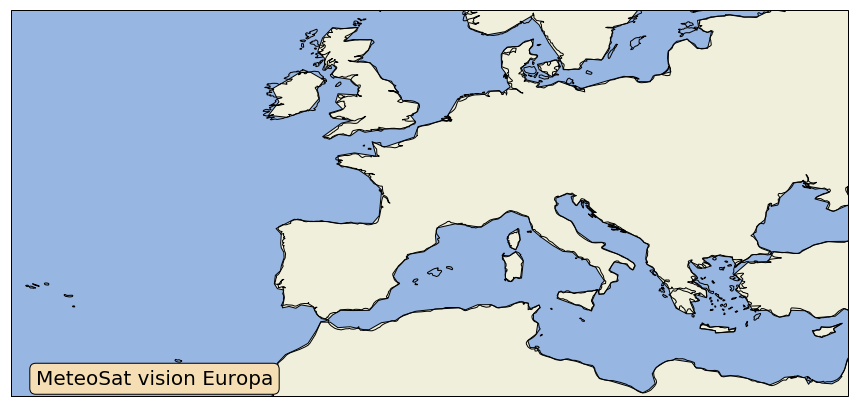

In [627]:
plot_map()